Extract features from EmoDB dataset

In [101]:
import librosa
import os
import numpy as np
import pandas as pd

In [2]:
example_audio = 'datasets/EmoDB/03a01Fa.wav'
samples, sample_rate = librosa.load(example_audio, sr=None)

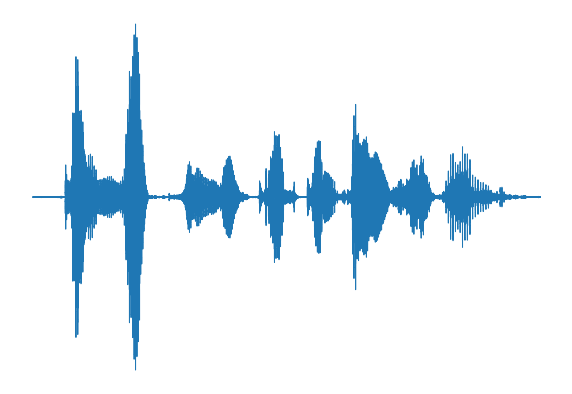

In [3]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.axis('off')
librosa.display.waveshow(samples, sr=sample_rate)

C:\Users\Nicolas Facchinetti\.conda\envs\thesis\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


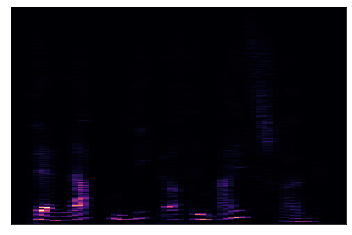

In [4]:
# convert to spectrogram
sgram = librosa.stft(samples, n_fft=2048, hop_length=512)
librosa.display.specshow(sgram)

C:\Users\Nicolas Facchinetti\AppData\Local\Temp\ipykernel_14992\29967690.py:2: FutureWarning: Pass y=[ 0.00067139  0.00308228  0.00253296 ... -0.00231934 -0.00186157
 -0.00186157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_scale_sgram = librosa.feature.melspectrogram(samples, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=64)


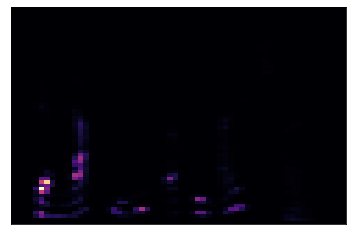

In [5]:
# use the mel-scale instead of raw frequency
mel_scale_sgram = librosa.feature.melspectrogram(samples, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=64)
librosa.display.specshow(mel_scale_sgram)

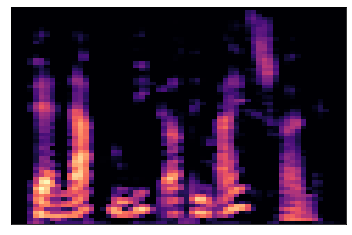

In [6]:
# use the decibel scale to get the final Mel Spectrogram
log_mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(log_mel_sgram, sr=sample_rate)

Create Pandas DataFrame with filename and label

In [7]:
label2name = {
    "L": "Boredom",
    "A": "Fear",
    "E": "Disgust",
    "F": "Happiness",
    "T": "Sadness",
    "W": "Anger",
    "N": "Neutral"
}
  
dir_path = 'datasets/EmoDB'
data = []
samples_list = []
for filename in os.listdir(dir_path):
    samples, sr = librosa.load(os.path.join(dir_path, filename), sr=None)
    samples_list.append(samples)
    length = len(samples)/sr
    
    cat = filename[5]
    data.append([filename, cat, length])
    
    
df_info = pd.DataFrame(data, columns=['filename', 'label', 'length'])
df_info

,filename,label,length
0,03a01Fa.wav,F,1.898250
1,03a01Nc.wav,N,1.611250
2,03a01Wa.wav,W,1.877813
3,03a02Fc.wav,F,2.006250
4,03a02Nc.wav,N,1.439812
...,...,...,...
530,16b10Lb.wav,L,3.442687
531,16b10Tb.wav,T,3.500625
532,16b10Td.wav,T,3.934188
533,16b10Wa.wav,W,2.414125


Deal with different lenghts

In [8]:
df_info["length"].describe()

count    535.000000
mean       2.779612
std        1.028189
min        1.225500
25%        2.026594
50%        2.590187
75%        3.308406
max        8.978250
Name: length, dtype: float64

Let's keep a length of 3.3, pad the shorter while split the longer. Throw away samples below minimum lenght 1.22

In [9]:
samples_list[0], len(samples_list[0])/sample_rate

(array([ 0.00067139,  0.00308228,  0.00253296, ..., -0.00231934,
        -0.00186157, -0.00186157], dtype=float32),
 1.89825)

In [10]:
buffer_length = 3.3*sample_rate
padded = librosa.util.pad_center(samples_list[0], size=buffer_length)
padded, len(padded)/sample_rate

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 3.3)

In [11]:
def split_sample(audio, length, minimum):
    samples_total = len(audio)
    samples_wrote = 0
    segments = []
    
    to_process = samples_total - samples_wrote
    while to_process > minimum:
        segment = audio[samples_wrote : (samples_wrote + length)]
        segments.append(segment)
        samples_wrote += length
        to_process = samples_total - samples_wrote
    return segments

In [12]:
len(samples_list[119])/sample_rate

5.1574375

In [13]:
splitted = split_sample(samples_list[119], int(buffer_length), int(1.22*sample_rate))
splitted

[array([ 0.00238037,  0.00189209,  0.00140381, ..., -0.00283813,
        -0.00283813, -0.00283813], dtype=float32),
 array([-0.00283813, -0.00283813, -0.00332642, ...,  0.        ,
         0.        ,  0.        ], dtype=float32)]

Split and pad all the samples, then extract log Mel-specotrograms from all the samples

In [14]:
df_info.iloc[0]

filename    03a01Fa.wav
label                 F
length          1.89825
Name: 0, dtype: object

In [34]:
mod_samples = []
sgram_list = []
mod_data = []
for count, samples in enumerate(samples_list):
    metadata = df_info.iloc[count]
    
    # split larger segmtents
    samples = [samples]
    if metadata["length"] >= buffer_length/sample_rate:
        samples = split_sample(samples[0], int(buffer_length), int(1.22*sample_rate))
    
    # pad segments
    for num, s in enumerate(samples):
        padded = librosa.util.pad_center(s, size=buffer_length)
        mod_samples.append(padded)
        mod_data.append([metadata["filename"]+str(num), metadata["label"], len(padded)/sample_rate])
        
        # compute log mel-spectrograms
        mel_scale_sgram = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
        log_mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        sgram_list.append(log_mel_sgram)
df_info_mod = pd.DataFrame(mod_data, columns=['filename', 'label', 'length'])
df_info_mod

,filename,label,length
0,03a01Fa.wav0,F,3.3
1,03a01Nc.wav0,N,3.3
2,03a01Wa.wav0,W,3.3
3,03a02Fc.wav0,F,3.3
4,03a02Nc.wav0,N,3.3
...,...,...,...
560,16b10Lb.wav0,L,3.3
561,16b10Tb.wav0,T,3.3
562,16b10Td.wav0,T,3.3
563,16b10Wa.wav0,W,3.3


In [17]:
df_info_mod.label.value_counts()

W    128
T     83
L     82
N     79
F     71
A     69
E     53
Name: label, dtype: int64

Split in train/test set

In [24]:
sgram_list, sgram_list[0].shape

([array([[67.644196, 72.241135, 71.464455, ..., 82.73243 , 78.636826,
          67.644196],
         [67.644196, 67.644196, 67.644196, ..., 67.644196, 67.644196,
          67.644196],
         [67.644196, 67.644196, 67.644196, ..., 67.644196, 67.644196,
          67.644196],
         ...,
         [67.644196, 67.644196, 67.644196, ..., 67.644196, 67.644196,
          67.644196],
         [67.644196, 67.644196, 67.644196, ..., 67.644196, 67.644196,
          67.644196],
         [67.644196, 67.644196, 67.644196, ..., 67.644196, 67.644196,
          67.644196]], dtype=float32),
  array([[75.629234, 85.57466 , 84.93049 , ..., 79.02701 , 80.50172 ,
          81.83814 ],
         [74.34102 , 74.34102 , 74.34102 , ..., 74.34102 , 74.34102 ,
          74.34102 ],
         [74.34102 , 74.34102 , 74.34102 , ..., 74.34102 , 74.34102 ,
          74.34102 ],
         ...,
         [74.34102 , 74.34102 , 74.34102 , ..., 74.34102 , 74.34102 ,
          74.34102 ],
         [74.34102 , 74.34102 , 74.

In [35]:
X = np.array(sgram_list)
X.shape

(565, 128, 104)

In [36]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X.shape

(565, 128, 104, 1)

In [42]:
df_info_mod["label"]

0      F
1      N
2      W
3      F
4      N
      ..
560    L
561    T
562    T
563    W
564    W
Name: label, Length: 565, dtype: object

In [49]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(df_info_mod["label"]).reshape(-1,1)).toarray()
encoder.categories_, Y, Y.shape

([array(['A', 'E', 'F', 'L', 'N', 'T', 'W'], dtype=object)],
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (565, 7))

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=30, shuffle=True, stratify=Y)
x_train.shape , y_train.shape, x_test.shape, y_test.shape

((452, 128, 104, 1), (452, 7), (113, 128, 104, 1), (113, 7))

Define a model for SER

In [162]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, Input

In [149]:
model = Sequential()
model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu', strides=(1, 1)), input_shape = (None, 128, 104,1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu', strides=(1, 1))))
model.add(TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4))))

model.add(TimeDistributed(Conv2D(128, kernel_size=(3, 3), activation='relu', strides=(1, 1))))
model.add(TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4))))

# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
# model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
model.add(TimeDistributed(Flatten()))

# define LSTM model
model.add(LSTM(128, return_sequences=True))
model.add(Dense(len(label2name), activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_162 (TimeDi (None, None, 126, 102, 64 640       
_________________________________________________________________
time_distributed_163 (TimeDi (None, None, 63, 51, 64)  0         
_________________________________________________________________
time_distributed_164 (TimeDi (None, None, 61, 49, 64)  36928     
_________________________________________________________________
time_distributed_165 (TimeDi (None, None, 15, 12, 64)  0         
_________________________________________________________________
time_distributed_166 (TimeDi (None, None, 13, 10, 128) 73856     
_________________________________________________________________
time_distributed_167 (TimeDi (None, None, 3, 2, 128)   0         
_________________________________________________________________
time_distributed_168 (TimeDi (None, None, 768)       

In [122]:
x_train.shape

(452, 128, 104, 1)

In [134]:
x_train.reshape((452, 2, 64, 104, 1))

array([[[[[ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ],
          ...,
          [ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ]],

         [[ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ],
          ...,
          [ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ]],

         [[ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ],
          ...,
          [ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ]],

         ...,

         [[ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ],
          ...,
          [ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ]],

         [[ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ],
          ...,
          [ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ]],

         [[ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ],
          ...,
          [ 88.08621 ],
          [ 88.08621 ],
          [ 88.08621 ]]],


        [[[ 88.08

In [150]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50


ValueError: in user code:

    C:\Users\Nicolas Facchinetti\.conda\envs\thesis\lib\site-packages\tensorflow\python\keras\engine\training.py:862 train_function  *
        return step_function(self, iterator)
    C:\Users\Nicolas Facchinetti\.conda\envs\thesis\lib\site-packages\tensorflow\python\keras\engine\training.py:852 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Nicolas Facchinetti\.conda\envs\thesis\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Nicolas Facchinetti\.conda\envs\thesis\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Nicolas Facchinetti\.conda\envs\thesis\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Nicolas Facchinetti\.conda\envs\thesis\lib\site-packages\tensorflow\python\keras\engine\training.py:845 run_step  **
        outputs = model.train_step(data)
    C:\Users\Nicolas Facchinetti\.conda\envs\thesis\lib\site-packages\tensorflow\python\keras\engine\training.py:802 train_step
        y_pred = self(x, training=True)
    C:\Users\Nicolas Facchinetti\.conda\envs\thesis\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1040 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Nicolas Facchinetti\.conda\envs\thesis\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:215 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_63 is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: (None, 128, 104, 1)


In [175]:
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D, LSTM, TimeDistributed, Input
model = Sequential()
model.add(TimeDistributed(Conv1D(64, kernel_size=(3), activation='relu', strides=(1)), input_shape = (128, 104,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2), strides=(2))))

model.add(TimeDistributed(Conv1D(64, kernel_size=(3), activation='relu', strides=(1))))
model.add(TimeDistributed(MaxPooling1D(pool_size=(4), strides=(4))))

model.add(TimeDistributed(Conv1D(128, kernel_size=(3), activation='relu', strides=(1))))
model.add(TimeDistributed(MaxPooling1D(pool_size=(4), strides=(4))))

# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
# model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
model.add(TimeDistributed(Flatten()))

# define LSTM model
model.add(LSTM(128, return_sequences=True))
model.add(Flatten())
model.add(Dense(len(label2name), activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_255 (TimeDi (None, 128, 102, 64)      256       
_________________________________________________________________
time_distributed_256 (TimeDi (None, 128, 51, 64)       0         
_________________________________________________________________
time_distributed_257 (TimeDi (None, 128, 49, 64)       12352     
_________________________________________________________________
time_distributed_258 (TimeDi (None, 128, 12, 64)       0         
_________________________________________________________________
time_distributed_259 (TimeDi (None, 128, 10, 128)      24704     
_________________________________________________________________
time_distributed_260 (TimeDi (None, 128, 2, 128)       0         
_________________________________________________________________
time_distributed_261 (TimeDi (None, 128, 256)        

In [176]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
15/15 [==============================] - 12s 419ms/step - loss: 2.6645 - accuracy: 0.1681 - val_loss: 2.1346 - val_accuracy: 0.2389
Epoch 2/50
15/15 [==============================] - 5s 303ms/step - loss: 1.9961 - accuracy: 0.2412 - val_loss: 1.9876 - val_accuracy: 0.1770
Epoch 3/50
15/15 [==============================] - 5s 303ms/step - loss: 2.0046 - accuracy: 0.1792 - val_loss: 1.9862 - val_accuracy: 0.2478
Epoch 4/50
15/15 [==============================] - 5s 303ms/step - loss: 1.9100 - accuracy: 0.2633 - val_loss: 1.8669 - val_accuracy: 0.3805
Epoch 5/50
15/15 [==============================] - 5s 303ms/step - loss: 1.8161 - accuracy: 0.3119 - val_loss: 1.7273 - val_accuracy: 0.3097
Epoch 6/50
15/15 [==============================] - 5s 305ms/step - loss: 1.6285 - accuracy: 0.3783 - val_loss: 1.5699 - val_accuracy: 0.3451
Epoch 7/50
15/15 [==============================] - 5s 305ms/step - loss: 1.4752 - accuracy: 0.4137 - val_loss: 1.4355 - val_accuracy: 0.4602
Epoch

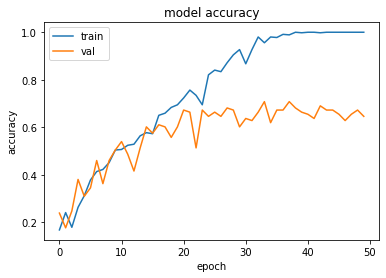

In [178]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

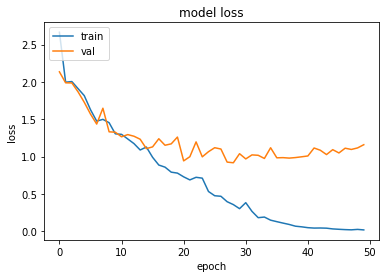

In [179]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()